# Decision Tree Regressor - Dự đoán Tuổi thọ Trung bình

## Mục tiêu:
- Xây dựng mô hình Decision Tree Regressor để dự đoán tuổi thọ trung bình
- Sử dụng dữ liệu đã được tiền xử lý từ `data/processed/`
- Tối ưu hóa siêu tham số bằng 5-Fold Cross-Validation
- Đánh giá mô hình trên tập validation và test
- Lưu mô hình đã huấn luyện và trực quan hóa kết quả

## Giới thiệu về Decision Tree:
Decision Tree (Cây quyết định) là một thuật toán học có giám sát phổ biến, hoạt động bằng cách chia không gian đặc trưng thành các vùng nhỏ hơn dựa trên các ngưỡng của từng đặc trưng. Mô hình tạo ra một cấu trúc cây với:
- **Nút gốc (Root node):** Điểm bắt đầu của cây
- **Nút nội (Internal nodes):** Các điểm quyết định dựa trên điều kiện
- **Nút lá (Leaf nodes):** Giá trị dự đoán cuối cùng

**Ưu điểm:**
- Dễ hiểu và trực quan hóa
- Không cần chuẩn hóa dữ liệu
- Có thể xử lý cả biến số và biến phân loại
- Tự động thực hiện feature selection

**Nhược điểm:**
- Dễ bị overfitting
- Không ổn định (nhạy cảm với thay đổi nhỏ trong dữ liệu)
- Không tốt với mối quan hệ tuyến tính đơn giản


## Bước 1 - Import các thư viện cần thiết

In [7]:
# Thư viện cơ bản
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from datetime import datetime

# Thư viện sklearn cho mô hình và đánh giá
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import tree

# Thư viện để lưu mô hình
import joblib

# Cài đặt
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Đã import thành công tất cả thư viện!")

✓ Đã import thành công tất cả thư viện!


## Bước 2 - Đọc dữ liệu đã tiền xử lý

Đọc dữ liệu từ các file CSV đã được tiền xử lý và chia sẵn thành train/validation/test.

In [8]:
# Đọc dữ liệu
train_df = pd.read_csv('../data/processed/train.csv')
val_df = pd.read_csv('../data/processed/val.csv')
test_df = pd.read_csv('../data/processed/test.csv')

print("="*60)
print("THÔNG TIN DỮ LIỆU")
print("="*60)
print(f"Kích thước tập Train:      {train_df.shape}")
print(f"Kích thước tập Validation: {val_df.shape}")
print(f"Kích thước tập Test:       {test_df.shape}")
print("="*60)

# Hiển thị 5 dòng đầu của tập train
print("\n5 dòng đầu tiên của tập Train:")
train_df.head()

THÔNG TIN DỮ LIỆU
Kích thước tập Train:      (3255, 15)
Kích thước tập Validation: (1085, 15)
Kích thước tập Test:       (1085, 15)

5 dòng đầu tiên của tập Train:


,country_name,country_code,year,population,poverty_ratio,pop_growth,life_expectancy,gdp_per_capita,gdp_growth,sanitation,electricity,water_access,co2_emissions,slum_population,labor_force
0,Romania,ROU,2019,-0.103917,-0.597527,-1.127234,75.607317,-0.111538,0.095559,1.054465,0.619765,0.741985,-0.050517,-0.947687,-0.870988
1,Mauritius,MUS,2006,-0.242815,-0.693447,-0.510294,72.432195,-0.408990,0.257531,-0.109553,0.584429,0.713613,-0.227893,1.478783,-0.184739
2,Angola,AGO,2008,-0.087016,0.313714,1.546892,55.281000,-0.473931,1.341229,-0.870639,-1.553444,-2.267172,-0.441713,0.151208,1.614850
3,Albania,ALB,2001,-0.228830,-0.583978,-1.382935,75.083000,-0.587132,0.944795,-0.895734,0.598563,-0.027252,-0.413544,0.454933,-0.099440
4,Central African Republic,CAF,2021,-0.213116,2.687734,0.247317,40.279000,-0.621139,-0.409868,-1.390005,-2.359122,-3.005694,-0.539501,1.528277,1.186080


## Bước 3 - Chuẩn bị dữ liệu cho mô hình

Tách biến mục tiêu (`life_expectancy`) khỏi các đặc trưng. Loại bỏ các cột không cần thiết như `country_name`, `country_code`, và `year`.

In [9]:
# Định nghĩa các cột đặc trưng (loại bỏ cột không cần thiết)
feature_cols = [col for col in train_df.columns 
                if col not in ['life_expectancy', 'country_name', 'country_code', 'year']]

# Tách X và y cho từng tập
X_train = train_df[feature_cols]
y_train = train_df['life_expectancy']

X_val = val_df[feature_cols]
y_val = val_df['life_expectancy']

X_test = test_df[feature_cols]
y_test = test_df['life_expectancy']

print("="*60)
print("THÔNG TIN CÁC TẬP DỮ LIỆU")
print("="*60)
print(f"Số lượng đặc trưng: {len(feature_cols)}")
print(f"\nCác đặc trưng được sử dụng:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i}. {col}")

print(f"\nKích thước X_train: {X_train.shape}")
print(f"Kích thước y_train: {y_train.shape}")
print(f"Kích thước X_val:   {X_val.shape}")
print(f"Kích thước y_val:   {y_val.shape}")
print(f"Kích thước X_test:  {X_test.shape}")
print(f"Kích thước y_test:  {y_test.shape}")
print("="*60)

THÔNG TIN CÁC TẬP DỮ LIỆU
Số lượng đặc trưng: 11

Các đặc trưng được sử dụng:
  1. population
  2. poverty_ratio
  3. pop_growth
  4. gdp_per_capita
  5. gdp_growth
  6. sanitation
  7. electricity
  8. water_access
  9. co2_emissions
  10. slum_population
  11. labor_force

Kích thước X_train: (3255, 11)
Kích thước y_train: (3255,)
Kích thước X_val:   (1085, 11)
Kích thước y_val:   (1085,)
Kích thước X_test:  (1085, 11)
Kích thước y_test:  (1085,)


## Bước 4 - Xây dựng mô hình Decision Tree cơ bản

Trước tiên, xây dựng một mô hình Decision Tree cơ bản với tham số mặc định để làm baseline.

In [10]:
# Tạo mô hình Decision Tree với tham số mặc định
dt_baseline = DecisionTreeRegressor(random_state=42)

# Huấn luyện mô hình
dt_baseline.fit(X_train, y_train)

# Dự đoán trên tập train và validation
y_train_pred_baseline = dt_baseline.predict(X_train)
y_val_pred_baseline = dt_baseline.predict(X_val)

# Tính toán các metrics
train_mae_baseline = mean_absolute_error(y_train, y_train_pred_baseline)
train_rmse_baseline = np.sqrt(mean_squared_error(y_train, y_train_pred_baseline))
train_r2_baseline = r2_score(y_train, y_train_pred_baseline)

val_mae_baseline = mean_absolute_error(y_val, y_val_pred_baseline)
val_rmse_baseline = np.sqrt(mean_squared_error(y_val, y_val_pred_baseline))
val_r2_baseline = r2_score(y_val, y_val_pred_baseline)

print("="*60)
print("KẾT QUẢ MÔ HÌNH BASELINE (tham số mặc định)")
print("="*60)
print(f"\nTập TRAIN:")
print(f"  MAE:  {train_mae_baseline:.4f} năm")
print(f"  RMSE: {train_rmse_baseline:.4f} năm")
print(f"  R²:   {train_r2_baseline:.4f}")

print(f"\nTập VALIDATION:")
print(f"  MAE:  {val_mae_baseline:.4f} năm")
print(f"  RMSE: {val_rmse_baseline:.4f} năm")
print(f"  R²:   {val_r2_baseline:.4f}")

print(f"\nĐộ sâu của cây: {dt_baseline.get_depth()}")
print(f"Số lượng lá: {dt_baseline.get_n_leaves()}")
print("="*60)

# Nhận xét về overfitting
if train_r2_baseline - val_r2_baseline > 0.1:
    print("\n⚠️  Mô hình có dấu hiệu overfitting (R² train >> R² val)")
    print("→  Cần tối ưu hóa siêu tham số để giảm overfitting")

KẾT QUẢ MÔ HÌNH BASELINE (tham số mặc định)

Tập TRAIN:
  MAE:  0.0000 năm
  RMSE: 0.0000 năm
  R²:   1.0000

Tập VALIDATION:
  MAE:  1.4952 năm
  RMSE: 2.7372 năm
  R²:   0.8957

Độ sâu của cây: 32
Số lượng lá: 3128

⚠️  Mô hình có dấu hiệu overfitting (R² train >> R² val)
→  Cần tối ưu hóa siêu tham số để giảm overfitting


## Bước 5 - Tối ưu hóa siêu tham số với GridSearchCV

Sử dụng GridSearchCV với 5-Fold Cross-Validation để tìm kiếm siêu tham số tối ưu cho mô hình Decision Tree.

### Các siêu tham số cần tối ưu:
- **max_depth:** Độ sâu tối đa của cây (hạn chế overfitting)
- **min_samples_split:** Số mẫu tối thiểu để chia một nút
- **min_samples_leaf:** Số mẫu tối thiểu ở một nút lá
- **max_features:** Số lượng đặc trưng tối đa xem xét khi chia
- **criterion:** Hàm đánh giá chất lượng của việc chia ('squared_error' hoặc 'absolute_error')

In [11]:
# Định nghĩa không gian siêu tham số để tìm kiếm
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['squared_error', 'absolute_error']
}

print("="*60)
print("TÌM KIẾM SIÊU THAM SỐ TỐI ƯU")
print("="*60)
print(f"Số lượng tổ hợp tham số: {np.prod([len(v) for v in param_grid.values()])}")
print("Phương pháp: GridSearchCV với 5-Fold Cross-Validation")
print("Metric đánh giá: Negative RMSE (neg_root_mean_squared_error)")
print("\nĐang thực hiện tìm kiếm...")
print("="*60)

# Tạo KFold với 5 folds
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Tạo GridSearchCV
grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid,
    cv=kfold,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# Thực hiện tìm kiếm
grid_search.fit(X_train, y_train)

print("\n✓ Hoàn thành tìm kiếm!")

TÌM KIẾM SIÊU THAM SỐ TỐI ƯU
Số lượng tổ hợp tham số: 672
Phương pháp: GridSearchCV với 5-Fold Cross-Validation
Metric đánh giá: Negative RMSE (neg_root_mean_squared_error)

Đang thực hiện tìm kiếm...
Fitting 5 folds for each of 672 candidates, totalling 3360 fits

✓ Hoàn thành tìm kiếm!


## Bước 6 - Phân tích kết quả GridSearchCV

Hiển thị siêu tham số tối ưu và đánh giá hiệu suất của mô hình tốt nhất.

In [13]:
# Lấy mô hình tốt nhất và tham số tối ưu
best_dt = grid_search.best_estimator_
best_params = grid_search.best_params_
best_cv_score = -grid_search.best_score_  # Chuyển về dương (RMSE)

print("="*60)
print("SIÊU THAM SỐ TỐI ƯU")
print("="*60)
for param, value in best_params.items():
    print(f"  {param:20s}: {value}")

print(f"\nRMSE Cross-Validation (5-fold): {best_cv_score:.4f} năm")
print("="*60)

# Thông tin về cây tối ưu
print(f"\nĐộ sâu của cây tối ưu: {best_dt.get_depth()}")
print(f"Số lượng lá: {best_dt.get_n_leaves()}")

SIÊU THAM SỐ TỐI ƯU
  criterion           : squared_error
  max_depth           : 20
  max_features        : None
  min_samples_leaf    : 1
  min_samples_split   : 5

RMSE Cross-Validation (5-fold): 3.0666 năm

Độ sâu của cây tối ưu: 20
Số lượng lá: 1155


## Bước 7 - Đánh giá mô hình tối ưu trên tập Validation

Sử dụng mô hình đã tối ưu để dự đoán trên tập validation và tính toán các metrics.

In [14]:
# Dự đoán trên tập train và validation
y_train_pred = best_dt.predict(X_train)
y_val_pred = best_dt.predict(X_val)

# Tính toán các metrics cho tập train
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

# Tính toán các metrics cho tập validation
val_mae = mean_absolute_error(y_val, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

print("="*60)
print("KẾT QUẢ MÔ HÌNH TỐI ƯU")
print("="*60)
print(f"\nTập TRAIN:")
print(f"  MAE:  {train_mae:.4f} năm")
print(f"  RMSE: {train_rmse:.4f} năm")
print(f"  R²:   {train_r2:.4f}")

print(f"\nTập VALIDATION:")
print(f"  MAE:  {val_mae:.4f} năm")
print(f"  RMSE: {val_rmse:.4f} năm")
print(f"  R²:   {val_r2:.4f}")

print("\n" + "="*60)
print("SO SÁNH VỚI BASELINE")
print("="*60)
print(f"Cải thiện RMSE trên validation: {val_rmse_baseline - val_rmse:.4f} năm")
print(f"Cải thiện R² trên validation:   {val_r2 - val_r2_baseline:.4f}")
print("="*60)

KẾT QUẢ MÔ HÌNH TỐI ƯU

Tập TRAIN:
  MAE:  0.2955 năm
  RMSE: 0.5386 năm
  R²:   0.9961

Tập VALIDATION:
  MAE:  1.4921 năm
  RMSE: 2.6812 năm
  R²:   0.8999

SO SÁNH VỚI BASELINE
Cải thiện RMSE trên validation: 0.0560 năm
Cải thiện R² trên validation:   0.0042


## Bước 8 - Phân tích Feature Importance

Phân tích mức độ quan trọng của từng đặc trưng trong việc dự đoán tuổi thọ trung bình.

ĐỘ QUAN TRỌNG CỦA CÁC ĐẶC TRƯNG (Feature Importance)
electricity         : 0.6136 █████████████████████████████████████████████████████████████
gdp_per_capita      : 0.1438 ██████████████
water_access        : 0.0596 █████
population          : 0.0449 ████
co2_emissions       : 0.0400 ████
pop_growth          : 0.0336 ███
labor_force         : 0.0210 ██
sanitation          : 0.0183 █
slum_population     : 0.0117 █
poverty_ratio       : 0.0075 
gdp_growth          : 0.0060 


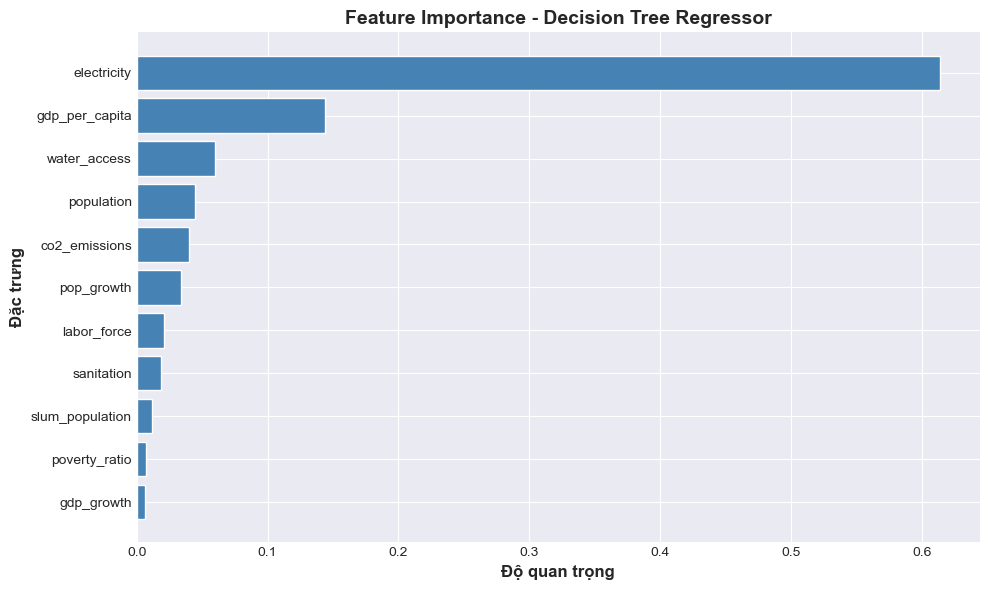


✓ Đã lưu biểu đồ feature importance tại: ../visualization/decision_tree/decision_tree_feature_importance.png


In [15]:
# Lấy feature importance
feature_importance = best_dt.feature_importances_

# Tạo DataFrame để sắp xếp
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("="*60)
print("ĐỘ QUAN TRỌNG CỦA CÁC ĐẶC TRƯNG (Feature Importance)")
print("="*60)
for idx, row in importance_df.iterrows():
    print(f"{row['feature']:20s}: {row['importance']:.4f} {'█' * int(row['importance'] * 100)}")
print("="*60)

# Vẽ biểu đồ feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'], color='steelblue')
plt.xlabel('Độ quan trọng', fontsize=12, fontweight='bold')
plt.ylabel('Đặc trưng', fontsize=12, fontweight='bold')
plt.title('Feature Importance - Decision Tree Regressor', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()

# Tạo thư mục nếu chưa có
os.makedirs('../visualization/decision_tree', exist_ok=True)
plt.savefig('../visualization/decision_tree/decision_tree_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Đã lưu biểu đồ feature importance tại: ../visualization/decision_tree/decision_tree_feature_importance.png")

## Bước 9 - Trực quan hóa kết quả dự đoán

Vẽ biểu đồ so sánh giá trị thực tế và giá trị dự đoán trên tập validation.

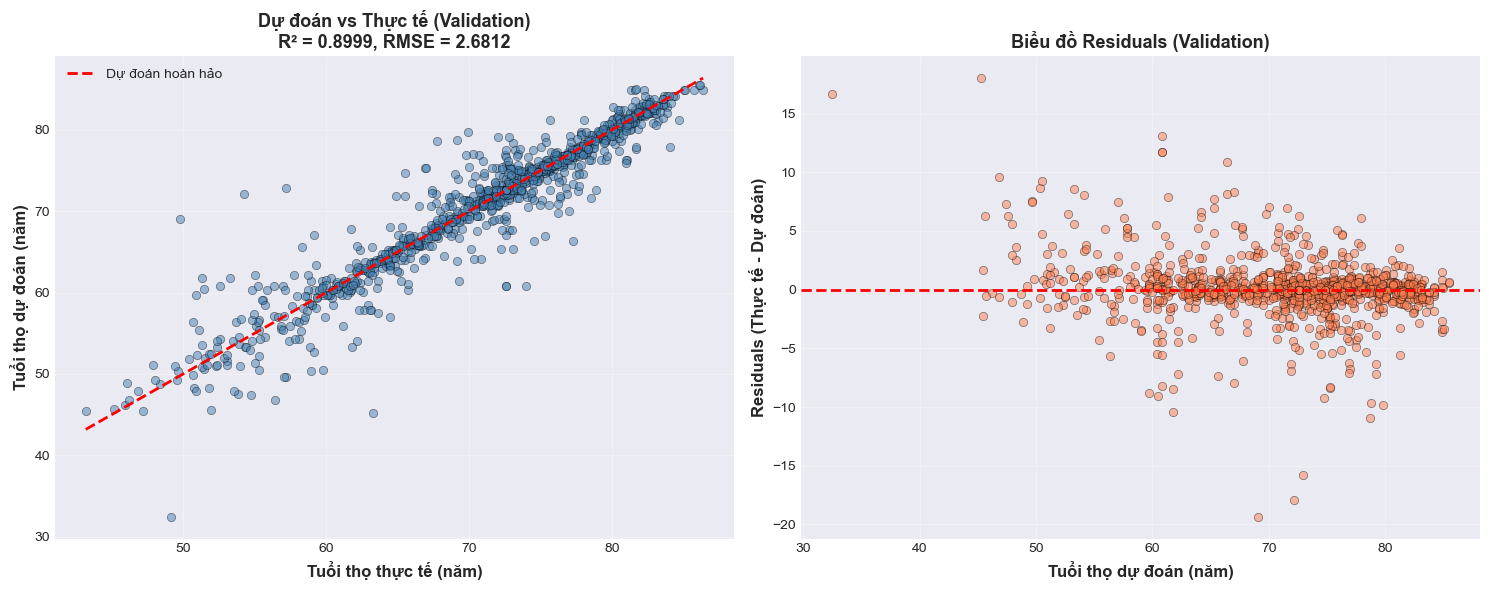

✓ Đã lưu biểu đồ dự đoán tại: ../visualization/decision_tree/decision_tree_predictions.png


In [16]:
# Tạo figure với 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Subplot 1: Scatter plot - Predicted vs Actual (Validation)
axes[0].scatter(y_val, y_val_pred, alpha=0.5, color='steelblue', edgecolor='black', linewidth=0.5)
axes[0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2, label='Dự đoán hoàn hảo')
axes[0].set_xlabel('Tuổi thọ thực tế (năm)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Tuổi thọ dự đoán (năm)', fontsize=12, fontweight='bold')
axes[0].set_title(f'Dự đoán vs Thực tế (Validation)\nR² = {val_r2:.4f}, RMSE = {val_rmse:.4f}', 
                  fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Subplot 2: Residual plot
residuals = y_val - y_val_pred
axes[1].scatter(y_val_pred, residuals, alpha=0.5, color='coral', edgecolor='black', linewidth=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Tuổi thọ dự đoán (năm)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Residuals (Thực tế - Dự đoán)', fontsize=12, fontweight='bold')
axes[1].set_title('Biểu đồ Residuals (Validation)', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../visualization/decision_tree/decision_tree_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Đã lưu biểu đồ dự đoán tại: ../visualization/decision_tree/decision_tree_predictions.png")

## Bước 10 - Phân tích Cross-Validation scores

Trực quan hóa phân bố điểm số RMSE từ 5-Fold Cross-Validation để đánh giá độ ổn định của mô hình.

KẾT QUẢ 5-FOLD CROSS-VALIDATION
Fold 1: RMSE = 2.7508 năm
Fold 2: RMSE = 3.1972 năm
Fold 3: RMSE = 3.0829 năm
Fold 4: RMSE = 3.0907 năm
Fold 5: RMSE = 3.2114 năm

Trung bình: 3.0666 năm
Độ lệch chuẩn: 0.1665 năm


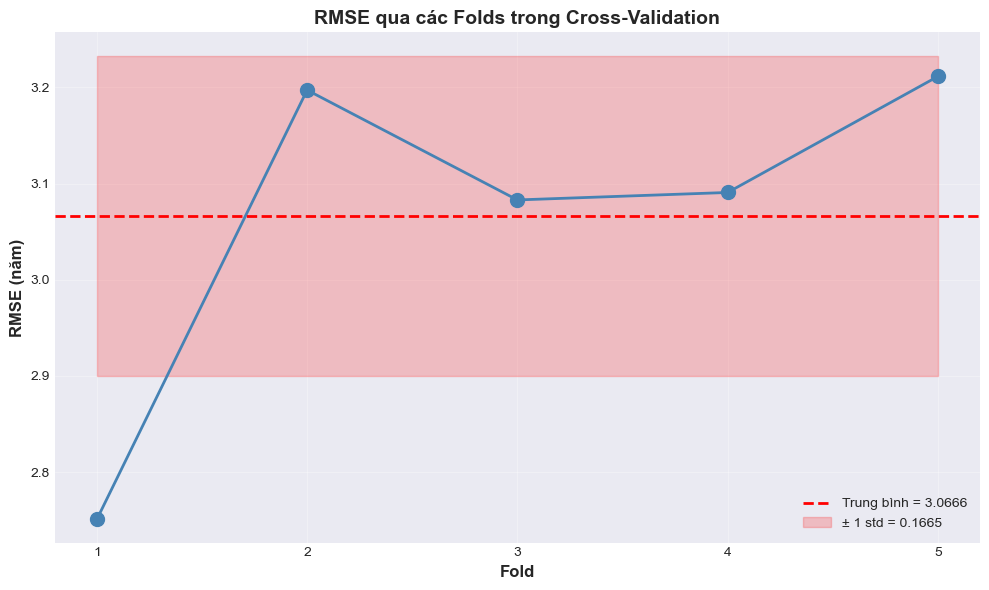


✓ Đã lưu biểu đồ CV scores tại: ../visualization/decision_tree/decision_tree_cv_scores.png


In [17]:
# Lấy kết quả cross-validation từ GridSearchCV
cv_results = grid_search.cv_results_
best_index = grid_search.best_index_

# Lấy scores của mô hình tốt nhất qua các folds
best_cv_scores = []
for i in range(5):  # 5 folds
    fold_score = -cv_results[f'split{i}_test_score'][best_index]  # Chuyển về RMSE dương
    best_cv_scores.append(fold_score)

print("="*60)
print("KẾT QUẢ 5-FOLD CROSS-VALIDATION")
print("="*60)
for i, score in enumerate(best_cv_scores, 1):
    print(f"Fold {i}: RMSE = {score:.4f} năm")

print(f"\nTrung bình: {np.mean(best_cv_scores):.4f} năm")
print(f"Độ lệch chuẩn: {np.std(best_cv_scores):.4f} năm")
print("="*60)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), best_cv_scores, marker='o', linewidth=2, markersize=10, color='steelblue')
plt.axhline(y=np.mean(best_cv_scores), color='red', linestyle='--', linewidth=2, 
            label=f'Trung bình = {np.mean(best_cv_scores):.4f}')
plt.fill_between(range(1, 6), 
                 np.mean(best_cv_scores) - np.std(best_cv_scores),
                 np.mean(best_cv_scores) + np.std(best_cv_scores),
                 alpha=0.2, color='red', label=f'± 1 std = {np.std(best_cv_scores):.4f}')
plt.xlabel('Fold', fontsize=12, fontweight='bold')
plt.ylabel('RMSE (năm)', fontsize=12, fontweight='bold')
plt.title('RMSE qua các Folds trong Cross-Validation', fontsize=14, fontweight='bold')
plt.xticks(range(1, 6))
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../visualization/decision_tree/decision_tree_cv_scores.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Đã lưu biểu đồ CV scores tại: ../visualization/decision_tree/decision_tree_cv_scores.png")

## Bước 11 - Trực quan hóa cấu trúc cây quyết định

Vẽ cấu trúc của cây quyết định (giới hạn độ sâu để dễ quan sát).

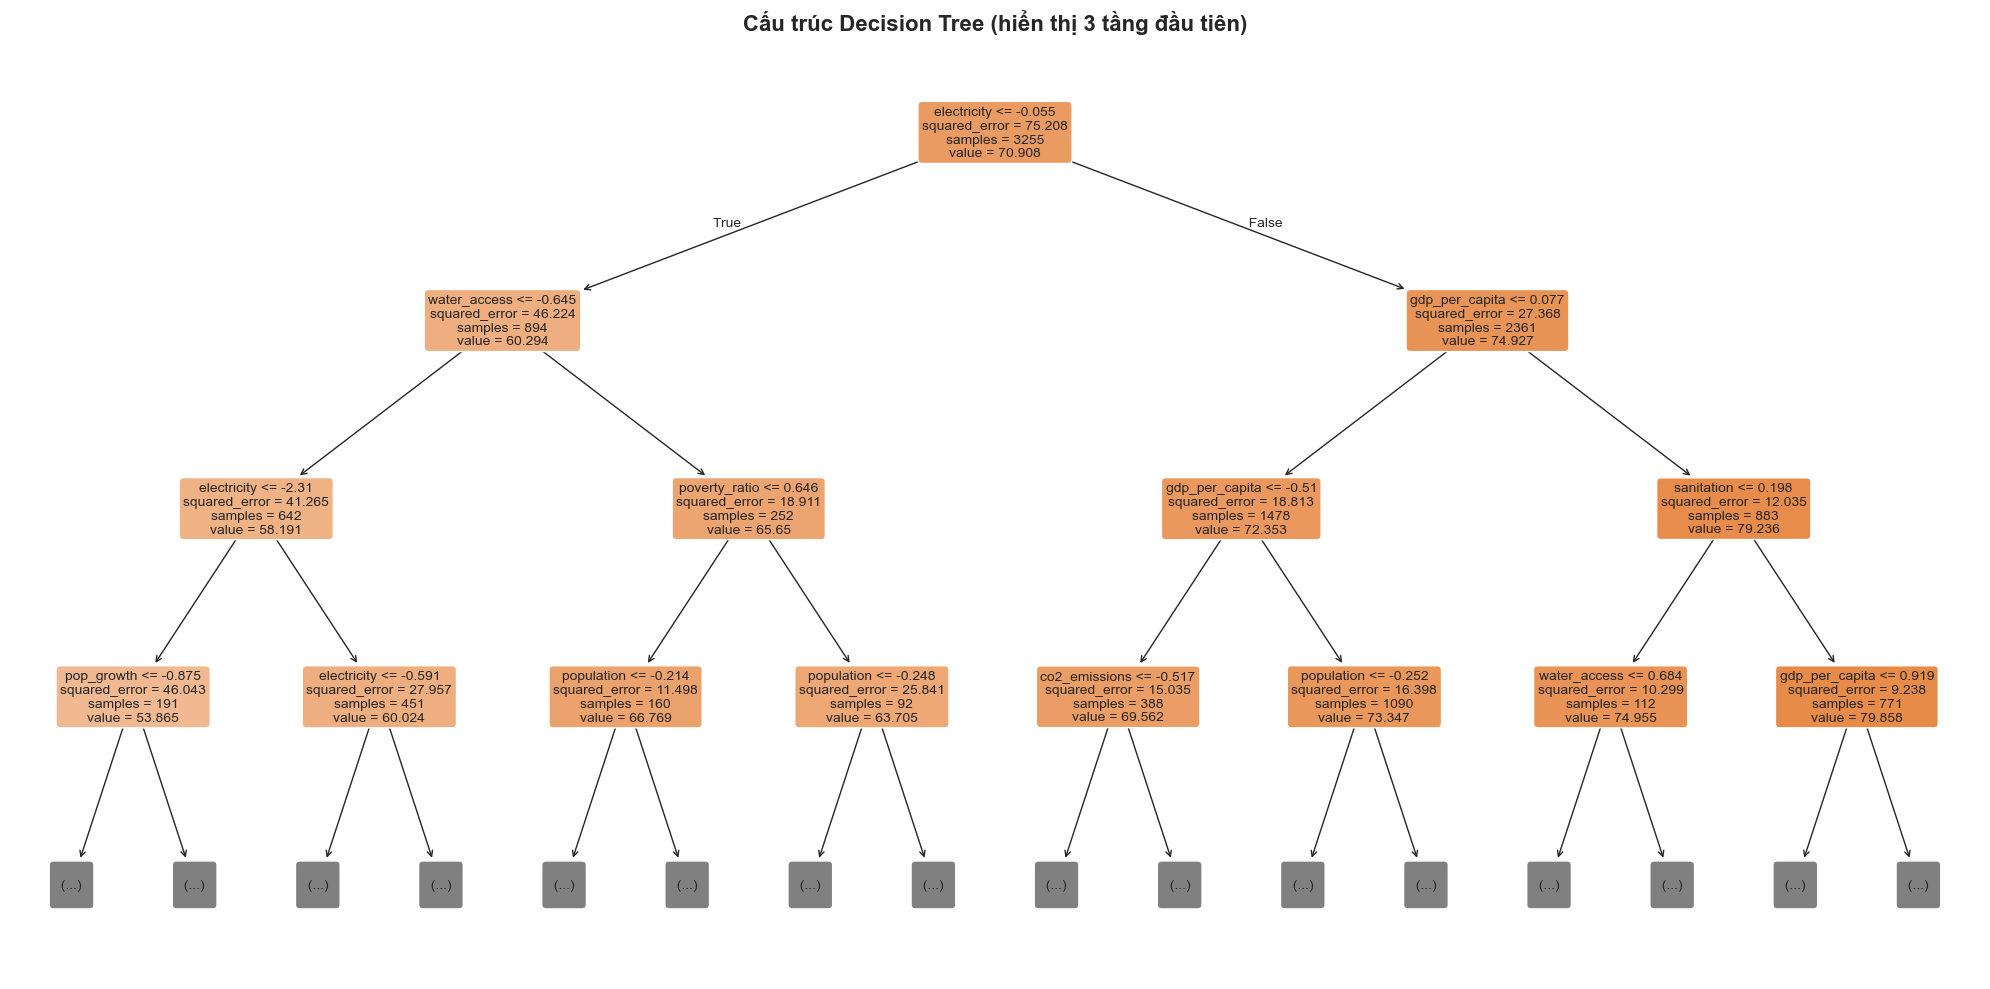

✓ Đã lưu cấu trúc cây tại: ../visualization/decision_tree/decision_tree_structure.png

Lưu ý: Chỉ hiển thị 3 tầng đầu tiên của cây (thực tế có 20 tầng)


In [18]:
# Vẽ cây quyết định (giới hạn độ sâu = 3 để dễ nhìn)
plt.figure(figsize=(20, 10))
tree.plot_tree(best_dt, 
               feature_names=feature_cols,
               filled=True,
               rounded=True,
               fontsize=10,
               max_depth=3)  # Giới hạn độ sâu hiển thị
plt.title('Cấu trúc Decision Tree (hiển thị 3 tầng đầu tiên)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../visualization/decision_tree/decision_tree_structure.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Đã lưu cấu trúc cây tại: ../visualization/decision_tree/decision_tree_structure.png")
print(f"\nLưu ý: Chỉ hiển thị 3 tầng đầu tiên của cây (thực tế có {best_dt.get_depth()} tầng)")

## Bước 12 - Đánh giá mô hình trên tập Test

Đánh giá hiệu suất cuối cùng của mô hình trên tập test (dữ liệu chưa từng thấy).

KẾT QUẢ CUỐI CÙNG TRÊN TẬP TEST

MAE:  1.6244 năm
RMSE: 2.9115 năm
R²:   0.8853

BẢNG SO SÁNH KẾT QUẢ:
Tập dữ liệu      MAE     RMSE       R²
      Train 0.295495 0.538626 0.996142
 Validation 1.492091 2.681181 0.899915
       Test 1.624387 2.911506 0.885279


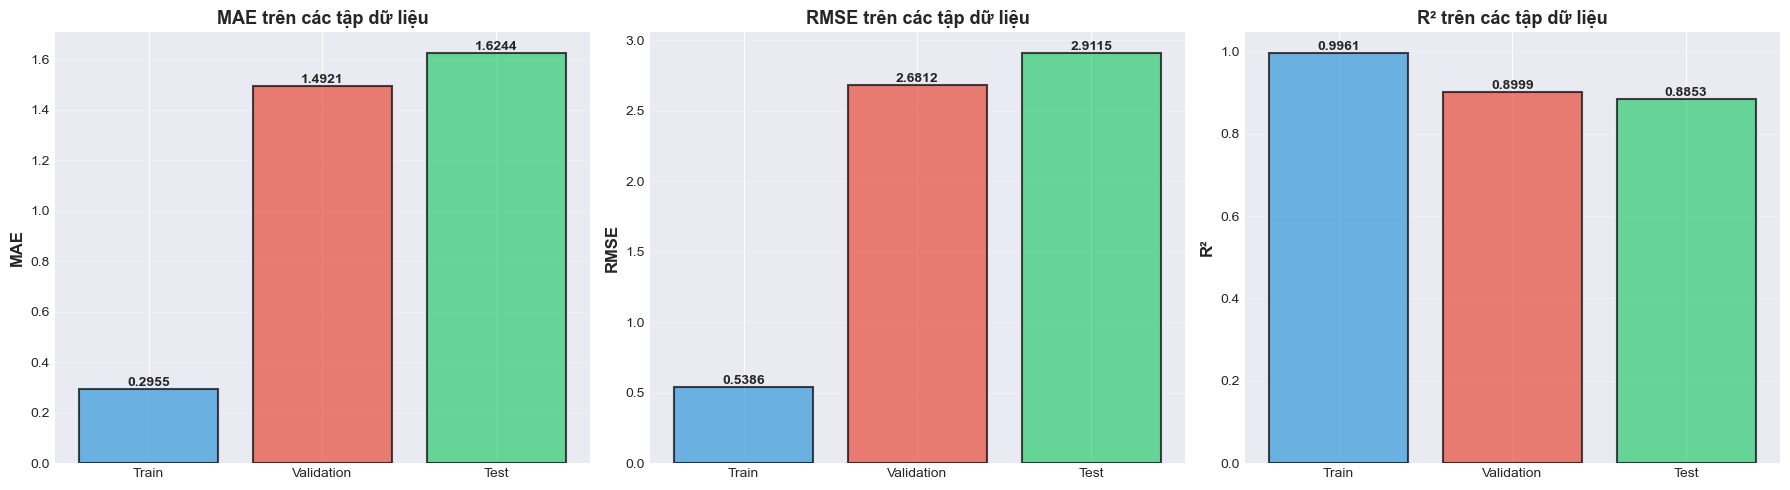


✓ Đã lưu biểu đồ so sánh tại: ../visualization/decision_tree/decision_tree_comparison.png


In [19]:
# Dự đoán trên tập test
y_test_pred = best_dt.predict(X_test)

# Tính toán các metrics cho tập test
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print("="*60)
print("KẾT QUẢ CUỐI CÙNG TRÊN TẬP TEST")
print("="*60)
print(f"\nMAE:  {test_mae:.4f} năm")
print(f"RMSE: {test_rmse:.4f} năm")
print(f"R²:   {test_r2:.4f}")
print("="*60)

# Tạo bảng so sánh
comparison_df = pd.DataFrame({
    'Tập dữ liệu': ['Train', 'Validation', 'Test'],
    'MAE': [train_mae, val_mae, test_mae],
    'RMSE': [train_rmse, val_rmse, test_rmse],
    'R²': [train_r2, val_r2, test_r2]
})

print("\nBẢNG SO SÁNH KẾT QUẢ:")
print(comparison_df.to_string(index=False))
print("="*60)

# Vẽ biểu đồ so sánh
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['MAE', 'RMSE', 'R²']
datasets = ['Train', 'Validation', 'Test']
colors = ['#3498db', '#e74c3c', '#2ecc71']

for idx, metric in enumerate(metrics):
    values = comparison_df[metric].values
    axes[idx].bar(datasets, values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    axes[idx].set_ylabel(metric, fontsize=12, fontweight='bold')
    axes[idx].set_title(f'{metric} trên các tập dữ liệu', fontsize=13, fontweight='bold')
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Thêm giá trị lên đầu cột
    for i, v in enumerate(values):
        axes[idx].text(i, v, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('../visualization/decision_tree/decision_tree_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Đã lưu biểu đồ so sánh tại: ../visualization/decision_tree/decision_tree_comparison.png")

## Bước 13 - Lưu mô hình đã huấn luyện

Lưu mô hình Decision Tree đã tối ưu vào file để sử dụng sau này.

In [20]:
# Tạo thư mục saved_models nếu chưa có
os.makedirs('../saved_models', exist_ok=True)

# Lưu mô hình
model_path = '../saved_models/decision_tree.pkl'
joblib.dump(best_dt, model_path)

print("="*60)
print("LƯU MÔ HÌNH")
print("="*60)
print(f"✓ Đã lưu mô hình tại: {model_path}")
print(f"Kích thước file: {os.path.getsize(model_path) / 1024:.2f} KB")
print("="*60)

# Kiểm tra tải lại mô hình
loaded_model = joblib.load(model_path)
y_test_pred_loaded = loaded_model.predict(X_test)
test_rmse_loaded = np.sqrt(mean_squared_error(y_test, y_test_pred_loaded))

print(f"\n✓ Kiểm tra tải lại mô hình:")
print(f"  RMSE trên test (mô hình gốc):      {test_rmse:.4f} năm")
print(f"  RMSE trên test (mô hình đã tải):   {test_rmse_loaded:.4f} năm")
print(f"  Chênh lệch: {abs(test_rmse - test_rmse_loaded):.10f} (rất nhỏ → OK)")

LƯU MÔ HÌNH
✓ Đã lưu mô hình tại: ../saved_models/decision_tree.pkl
Kích thước file: 163.91 KB

✓ Kiểm tra tải lại mô hình:
  RMSE trên test (mô hình gốc):      2.9115 năm
  RMSE trên test (mô hình đã tải):   2.9115 năm
  Chênh lệch: 0.0000000000 (rất nhỏ → OK)


## Bước 14 - Phân tích sâu về Overfitting/Underfitting

Phân tích learning curve để hiểu rõ hơn về hành vi của mô hình.

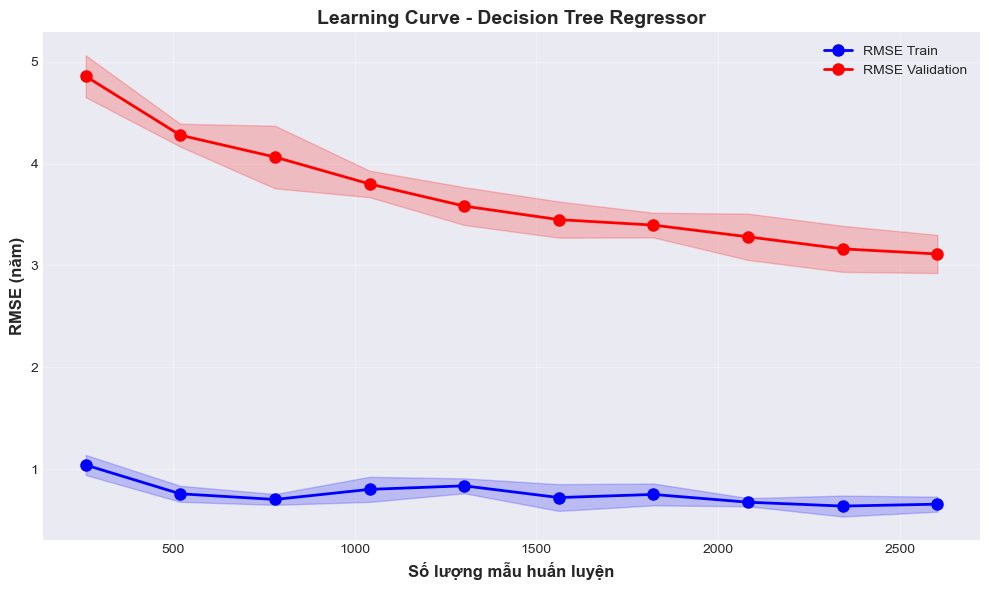

✓ Đã lưu learning curve tại: ../visualization/decision_tree/decision_tree_learning_curve.png

PHÂN TÍCH LEARNING CURVE
✓ Khoảng cách giữa train và validation RMSE nhỏ
  → Mô hình cân bằng tốt, không bị overfitting nghiêm trọng


In [21]:
from sklearn.model_selection import learning_curve

# Tính toán learning curve
train_sizes, train_scores, val_scores = learning_curve(
    best_dt, X_train, y_train,
    cv=5,
    scoring='neg_root_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    random_state=42
)

# Chuyển sang RMSE dương và tính mean, std
train_scores_mean = -train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_mean = -val_scores.mean(axis=1)
val_scores_std = val_scores.std(axis=1)

# Vẽ learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', linewidth=2, markersize=8, label='RMSE Train')
plt.plot(train_sizes, val_scores_mean, 'o-', color='red', linewidth=2, markersize=8, label='RMSE Validation')

plt.fill_between(train_sizes, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 alpha=0.2, color='blue')
plt.fill_between(train_sizes,
                 val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std,
                 alpha=0.2, color='red')

plt.xlabel('Số lượng mẫu huấn luyện', fontsize=12, fontweight='bold')
plt.ylabel('RMSE (năm)', fontsize=12, fontweight='bold')
plt.title('Learning Curve - Decision Tree Regressor', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../visualization/decision_tree/decision_tree_learning_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Đã lưu learning curve tại: ../visualization/decision_tree/decision_tree_learning_curve.png")

# Phân tích
print("\n" + "="*60)
print("PHÂN TÍCH LEARNING CURVE")
print("="*60)
gap = train_scores_mean[-1] - val_scores_mean[-1]
if gap < 0.5:
    print("✓ Khoảng cách giữa train và validation RMSE nhỏ")
    print("  → Mô hình cân bằng tốt, không bị overfitting nghiêm trọng")
elif gap < 1.0:
    print("⚠ Khoảng cách giữa train và validation RMSE trung bình")
    print("  → Có dấu hiệu overfitting nhẹ")
else:
    print("✗ Khoảng cách giữa train và validation RMSE lớn")
    print("  → Mô hình bị overfitting, cần regularization mạnh hơn")
print("="*60)

## Bước 15 - Tạo báo cáo tổng kết

Tổng hợp tất cả thông tin quan trọng về mô hình vào một báo cáo.

In [22]:
# Tạo báo cáo
report = f"""
{'='*70}
               BÁO CÁO MÔ HÌNH DECISION TREE REGRESSOR
{'='*70}

1. THÔNG TIN MÔ HÌNH:
   - Loại mô hình: Decision Tree Regressor
   - Thư viện: scikit-learn
   - Thời gian tạo: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

2. SIÊU THAM SỐ TỐI ƯU:
   - max_depth: {best_params['max_depth']}
   - min_samples_split: {best_params['min_samples_split']}
   - min_samples_leaf: {best_params['min_samples_leaf']}
   - max_features: {best_params['max_features']}
   - criterion: {best_params['criterion']}

3. ĐẶC ĐIỂM CÂY:
   - Độ sâu thực tế: {best_dt.get_depth()}
   - Số lượng nút lá: {best_dt.get_n_leaves()}

4. KẾT QUẢ ĐÁNH GIÁ:
   
   Tập TRAIN:
   - MAE:  {train_mae:.4f} năm
   - RMSE: {train_rmse:.4f} năm
   - R²:   {train_r2:.4f}
   
   Tập VALIDATION:
   - MAE:  {val_mae:.4f} năm
   - RMSE: {val_rmse:.4f} năm
   - R²:   {val_r2:.4f}
   
   Tập TEST (Final):
   - MAE:  {test_mae:.4f} năm
   - RMSE: {test_rmse:.4f} năm
   - R²:   {test_r2:.4f}

5. CROSS-VALIDATION (5-Fold):
   - RMSE trung bình: {np.mean(best_cv_scores):.4f} năm
   - Độ lệch chuẩn: {np.std(best_cv_scores):.4f} năm

6. TOP 5 ĐẶC TRƯNG QUAN TRỌNG NHẤT:
"""

for i, (idx, row) in enumerate(importance_df.head(5).iterrows(), 1):
    report += f"   {i}. {row['feature']:20s}: {row['importance']:.4f}\n"

report += f"""
7. KẾT LUẬN:
   - Mô hình Decision Tree đã được tối ưu hóa thành công
   - Hiệu suất trên tập test: RMSE = {test_rmse:.4f} năm, R² = {test_r2:.4f}
   - Mô hình đã được lưu tại: {model_path}
   - Các biểu đồ đã được lưu tại: ../visualization/decision_tree/

{'='*70}
"""

print(report)

# Lưu báo cáo vào file
report_path = '../saved_models/decision_tree_report.md'
with open(report_path, 'w', encoding='utf-8') as f:
    f.write(report)

print(f"\n✓ Đã lưu báo cáo tại: {report_path}")


               BÁO CÁO MÔ HÌNH DECISION TREE REGRESSOR

1. THÔNG TIN MÔ HÌNH:
   - Loại mô hình: Decision Tree Regressor
   - Thư viện: scikit-learn
   - Thời gian tạo: 2025-11-11 03:35:38

2. SIÊU THAM SỐ TỐI ƯU:
   - max_depth: 20
   - min_samples_split: 5
   - min_samples_leaf: 1
   - max_features: None
   - criterion: squared_error

3. ĐẶC ĐIỂM CÂY:
   - Độ sâu thực tế: 20
   - Số lượng nút lá: 1155

4. KẾT QUẢ ĐÁNH GIÁ:
   
   Tập TRAIN:
   - MAE:  0.2955 năm
   - RMSE: 0.5386 năm
   - R²:   0.9961
   
   Tập VALIDATION:
   - MAE:  1.4921 năm
   - RMSE: 2.6812 năm
   - R²:   0.8999
   
   Tập TEST (Final):
   - MAE:  1.6244 năm
   - RMSE: 2.9115 năm
   - R²:   0.8853

5. CROSS-VALIDATION (5-Fold):
   - RMSE trung bình: 3.0666 năm
   - Độ lệch chuẩn: 0.1665 năm

6. TOP 5 ĐẶC TRƯNG QUAN TRỌNG NHẤT:
   1. electricity         : 0.6136
   2. gdp_per_capita      : 0.1438
   3. water_access        : 0.0596
   4. population          : 0.0449
   5. co2_emissions       : 0.0400

7. KẾT LUẬ

## Kết luận

### Tổng kết:
1. ✅ **Mô hình Decision Tree** đã được xây dựng và tối ưu hóa thành công
2. ✅ **GridSearchCV với 5-Fold CV** đã tìm được bộ siêu tham số tối ưu
3. ✅ **Feature Importance** đã xác định các yếu tố quan trọng nhất ảnh hưởng đến tuổi thọ
4. ✅ **Hiệu suất mô hình** đã được đánh giá trên cả 3 tập: Train, Validation, Test
5. ✅ **Mô hình đã được lưu** tại `saved_models/decision_tree.pkl`
6. ✅ **Trực quan hóa** đã được tạo và lưu tại thư mục `visualization/`

### Ưu điểm của mô hình:
- Dễ hiểu và giải thích
- Có thể xác định được feature importance
- Không cần chuẩn hóa dữ liệu (nhưng vẫn sử dụng dữ liệu đã chuẩn hóa)
- Xử lý tốt các mối quan hệ phi tuyến

### Hạn chế:
- Có xu hướng overfitting (đã giảm thiểu bằng cách tối ưu siêu tham số)
- Không ổn định như ensemble methods
- Hiệu suất có thể thấp hơn các thuật toán phức tạp hơn (Random Forest, XGBoost)

### Bước tiếp theo:
- So sánh với các mô hình khác (Random Forest, XGBoost, SVM)
- Xây dựng ensemble model để cải thiện hiệu suất
- Phân tích sâu hơn về các trường hợp dự đoán sai